In [ ]:
!gdown --id 1SEprCaRetePqy5pNsFKA9rXwB1d3TGmx
!unzip -q capstone.zip

Downloading...
From: https://drive.google.com/uc?id=1SEprCaRetePqy5pNsFKA9rXwB1d3TGmx
To: /content/capstone.zip
2.55MB [00:00, 79.4MB/s]


In [ ]:
import os
import re
import itertools
import warnings
from joblib import dump

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats, signal
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

warnings.filterwarnings("ignore")
random_state = 42
activities = ["hair", "listen", "sidepump", "dab", "wipe", "gun", "elbow", "pointhigh"]
n_labels = len(activities)

In [ ]:
dfs = []

def load_data(activity, label, trails, subject):
    for trail in trails:
        df = pd.read_csv(os.path.join(subject, activity+str(trail)+".txt"), sep=" ", header=None)
        df = df[60:-60]
        df.columns = ["yaw", "pitch", "roll", "acc_x", "acc_y", "acc_z"]
        df["activity"] = [label for _ in range(len(df))]
        df["activityName"] = [activity for _ in range(len(df))]
        dfs.append(df)

load_data("hair", 0, [1, 2, 3, 4], "riyas")
load_data("listen", 1, [1, 2, 3, 4], "riyas")
load_data("sidepump", 2, [1, 2, 3, 4], "riyas")
load_data("dab", 3, [1, 2, 3, 4], "riyas")
load_data("wipe", 4, [1, 2, 3, 4], "riyas")
load_data("gun", 5, [1, 2, 3, 4], "riyas")
load_data("elbow", 6, [1, 2, 3, 4, 5, 6], "riyas")
load_data("pointhigh", 7, [1, 2, 3, 4], "riyas")

df = pd.concat(dfs)
df.shape

(85620, 8)

In [ ]:
def convert_to_timeseries(features, num_time_steps, num_features):
    data = np.reshape(features, newshape=(num_time_steps, num_features))
    return data.T

num_time_steps = 60
X = list()
y = list()
df_len = len(df)
for idx in range(0, df_len, num_time_steps//2):
    window_df = df[idx:idx+num_time_steps]
    labels = window_df["activity"].unique()
    if len(labels) != 1 or len(window_df) < num_time_steps:
        continue
    assert len(labels) == 1 and len(window_df) == num_time_steps
    features = window_df.drop(columns=["activity", "activityName"]).values
    features = convert_to_timeseries(features, num_time_steps=num_time_steps, num_features=6)
    X.append(features)
    y.append(labels)

X = np.array(X)
y = np.array(y)

X.shape, y.shape

((2839, 6, 60), (2839, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)
X_train.shape

(2271, 6, 60)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cmap='Reds'
        print("Normalized Confusion Matrix")
    else:
        cmap='Greens'
        print('Confusion Matrix Without Normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            上次验证集损失值改善后等待几个epoch
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            如果是True，为每个验证集损失值改善打印一条信息
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            监测数量的最小变化，以符合改进的要求
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''
        Saves model when validation loss decrease.
        验证损失减少时保存模型。
        '''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model, 'finish_model.pkl')                 # 这里会存储迄今最优的模型
        self.val_loss_min = val_loss

def plot_avg_loss_per_epoch(avg_train_losses, avg_valid_losses):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(avg_train_losses)+1), avg_train_losses, label='Training Loss')
    plt.plot(range(1,len(avg_valid_losses)+1), avg_valid_losses,label='Validation Loss')

    # find position of lowest validation loss
    minposs = avg_train_losses.index(min(avg_train_losses))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 2) # consistent scale
    plt.xlim(0, len(avg_train_losses)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_accuracy_per_epoch(train_accuracies, valid_accuracies):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1,len(valid_accuracies)+1), valid_accuracies,label='Valid Accuracy')

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.ylim(0, 1) # consistent scale
    plt.xlim(0, len(train_accuracies)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
class DLTrainer:
    def __init__(self, model, trainloader, validloader, testloader, criterion, optimizer, early_stopping, n_epochs, patience, is_time_series=False):
        self.model = model
        self.trainloader = trainloader
        self.validloader = validloader
        self.testloader = testloader
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.early_stopping = early_stopping
        self.n_epochs = n_epochs
        self.patience = patience
        self.is_time_series = is_time_series

        self.avg_train_losses = []
        self.avg_valid_losses = [] 
        self.train_accuracies = []
        self.valid_accuracies = []

    def train(self):
        self.model.cuda()
        for epoch in range(self.n_epochs):  # loop over the dataset multiple times
            train_correct, train_total, train_loss = self.train_epoch()
            valid_correct, valid_total, valid_loss = self.validate_epoch()

            # calculate average loss over an epoch
            train_accuracy = train_correct / train_total
            valid_accuracy = valid_correct / valid_total

            self.avg_train_losses.append(train_loss)
            self.avg_valid_losses.append(valid_loss)
            self.train_accuracies.append(train_accuracy)
            self.valid_accuracies.append(valid_accuracy)

            log_message = f'[{str(epoch)}/{str(self.n_epochs)}] train_loss: {train_loss:.5f} valid_loss: {valid_loss:.5f} train_accuracy: {train_accuracy:.5f} valid_accuracy: {valid_accuracy:.5f}'
            print(log_message)

            self.early_stopping(valid_loss, self.model)
            
            if self.early_stopping.early_stop:
                break

    def train_epoch(self):
        correct = 0
        total = 0
        losses = []

        self.model.train()
        for data in self.trainloader:
            inputs, labels = data

            inputs = inputs.to("cuda")
            labels = labels.to("cuda")

            self.optimizer.zero_grad()

            outputs = self.model(inputs.float())

            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        return correct, total, np.mean(losses)

    def validate_epoch(self):
        correct = 0
        total = 0
        losses = []

        self.model.eval()
        for data in validloader:
            inputs, labels = data

            inputs = inputs.to("cuda")
            labels = labels.to("cuda")

            outputs = self.model(inputs.float())
            loss = self.criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        return correct, total, np.mean(losses)

    def evaluate(self, dataloader):
        correct = 0
        total = 0
        actual = []
        expected = []

        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data

                inputs = inputs.to("cuda")
                labels = labels.to("cuda")
                outputs = self.model(inputs.float())
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                expected += labels.cpu()
                actual += predicted.cpu()

        return correct/total, (expected, actual)

    def show_evaluation(self):
        return self.avg_train_losses, self.avg_valid_losses, self.train_accuracies, self.valid_accuracies


In [ ]:
scaler = preprocessing.StandardScaler()
# https://stackoverflow.com/questions/53870113/using-standardscaler-on-3d-data
def scale_data(data, is_train=False):
    num_instances, num_time_steps, num_features = data.shape
    data = np.reshape(data, newshape=(-1, num_features))
    if is_train:
        data = scaler.fit_transform(data)
    else:
        data = scaler.transform(data)
    data = np.reshape(data, newshape=(num_instances, num_time_steps, num_features))
    return data

X_train = scale_data(X_train, is_train=True)
X_valid = scale_data(X_valid)
X_test = scale_data(X_test)
X_train.shape

(2271, 6, 60)

In [ ]:
class CNNDataset(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, idx):
        data = self.X[idx]
        target = self.y[idx][0]
        return data, target

    def __len__(self):
        return len(self.X)

def prepare_cnn_dataloader(X_train, X_valid, X_test, y_train, y_valid, y_test):
    traindataset = CNNDataset(X_train, y_train)

    trainloader = torch.utils.data.DataLoader(
        traindataset, 
        batch_size=100, 
        shuffle=True, 
        num_workers=4,
    )

    validdataset = CNNDataset(X_valid, y_valid)

    validloader = torch.utils.data.DataLoader(
        validdataset, 
        batch_size=100, 
        shuffle=True, 
        num_workers=4,
    )

    testdataset = CNNDataset(X_test, y_test)

    testloader = torch.utils.data.DataLoader(
        testdataset, 
        batch_size=100, 
        shuffle=True, 
        num_workers=4,
    )

    return trainloader, validloader, testloader

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(6, 32, 3)
        self.relu1 = nn.ReLU()
        self.dp1 = nn.Dropout(0.6)

        self.pool1 = nn.MaxPool1d(2)
        self.flat1 = nn.Flatten()
        self.dp2 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(928, 256)
        self.relu2 = nn.ReLU()
        self.dp3 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(256, 128)
        self.dp4 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(128, n_labels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dp1(x)

        x = self.pool1(x)
        x = self.flat1(x)
        x = self.dp2(x)

        x = self.fc1(x)
        x = self.relu2(x)
        x = self.dp3(x)

        x = self.fc2(x)
        x = self.dp4(x)

        x = self.fc3(x)
        
        return x

trainloader, validloader, testloader = prepare_cnn_dataloader(X_train, X_valid, X_test, y_train, y_valid, y_test)
inputs, labels = next(iter(trainloader))
model = CNN()
outputs = model(inputs.float())
labels[:1], outputs[:1]

(tensor([3]),
 tensor([[-0.2202, -0.1308,  0.0065,  0.1671,  0.1148, -0.1460,  0.0970, -0.1167]],
        grad_fn=<SliceBackward>))

In [ ]:
patience = 10
n_epochs = 1000

model = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
early_stopping = EarlyStopping(patience=patience)
trainloader, validloader, testloader = prepare_cnn_dataloader(X_train, X_valid, X_test, y_train, y_valid, y_test)

trainer = DLTrainer(model, trainloader, validloader, testloader, criterion, optimizer, early_stopping, n_epochs, patience, is_time_series=True)
trainer.train()

[0/1000] train_loss: 2.05859 valid_loss: 2.04704 train_accuracy: 0.16865 valid_accuracy: 0.17606
[1/1000] train_loss: 2.01368 valid_loss: 2.01711 train_accuracy: 0.20916 valid_accuracy: 0.15493
[2/1000] train_loss: 1.96278 valid_loss: 1.98254 train_accuracy: 0.22677 valid_accuracy: 0.22183
[3/1000] train_loss: 1.90464 valid_loss: 1.93873 train_accuracy: 0.26684 valid_accuracy: 0.30986
[4/1000] train_loss: 1.83675 valid_loss: 1.88454 train_accuracy: 0.30956 valid_accuracy: 0.40493
[5/1000] train_loss: 1.75706 valid_loss: 1.81501 train_accuracy: 0.34875 valid_accuracy: 0.47887
[6/1000] train_loss: 1.66062 valid_loss: 1.73131 train_accuracy: 0.39322 valid_accuracy: 0.55986
[7/1000] train_loss: 1.55246 valid_loss: 1.64145 train_accuracy: 0.45883 valid_accuracy: 0.69014
[8/1000] train_loss: 1.43799 valid_loss: 1.54483 train_accuracy: 0.52400 valid_accuracy: 0.74648
[9/1000] train_loss: 1.32871 valid_loss: 1.44198 train_accuracy: 0.57860 valid_accuracy: 0.78169
[10/1000] train_loss: 1.23566 

In [ ]:
cnn_valid_accuracy, cnn_valid_prediction = trainer.evaluate(validloader)
cnn_test_accuracy, cnn_test_prediction = trainer.evaluate(testloader)
cnn_valid_accuracy, cnn_test_accuracy

(0.9753521126760564, 0.9823943661971831)

Confusion Matrix Without Normalization


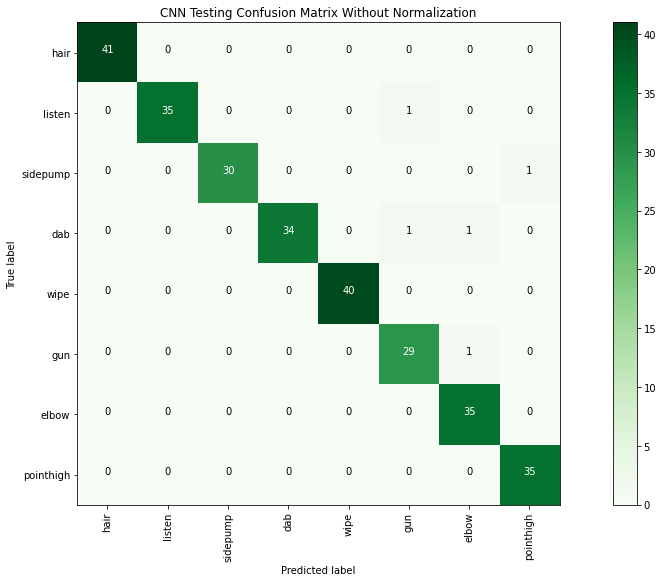

Normalized Confusion Matrix


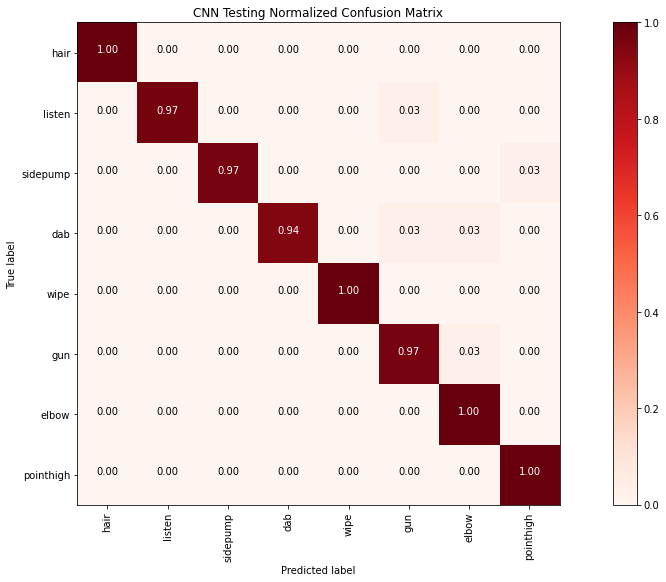

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(*cnn_test_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, title='CNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='CNN Testing Normalized Confusion Matrix')

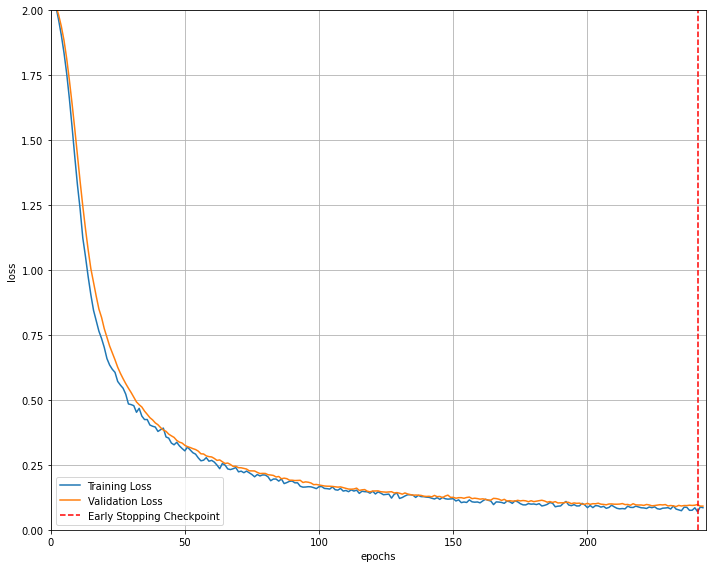

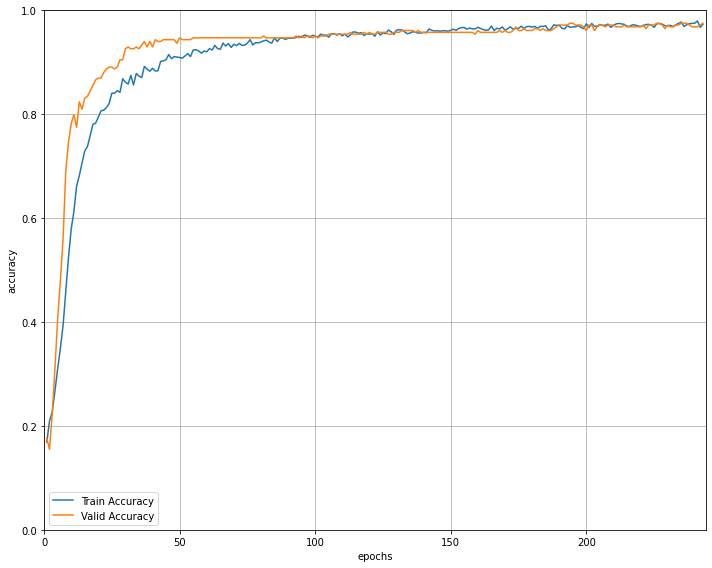

In [ ]:
avg_train_losses, avg_valid_losses, train_accuracies, valid_accuracies = trainer.show_evaluation()
plot_avg_loss_per_epoch(avg_train_losses, avg_valid_losses)
plot_accuracy_per_epoch(train_accuracies, valid_accuracies)

In [ ]:
torch.save(model.state_dict(), "cnn_model.pth")
dump(scaler, 'cnn_std_scaler.bin', compress=True)

['cnn_std_scaler.bin']

In [ ]:
dfs = []

load_data("hair", 0, [5,], "riyas")
load_data("listen", 1, [5,], "riyas")
load_data("sidepump", 2, [5,], "riyas")
load_data("dab", 3, [5,], "riyas")
load_data("wipe", 4, [5,], "riyas")
load_data("gun", 5, [5,], "riyas")
load_data("elbow", 6, [7, 8,], "riyas")
load_data("pointhigh", 7, [5,], "riyas")

df = pd.concat(dfs)
df.shape

(22390, 8)

In [ ]:
X = list()
y = list()
df_len = len(df)
for idx in range(0, df_len, num_time_steps//2):
    window_df = df[idx:idx+num_time_steps]
    labels = window_df["activity"].unique()
    if len(labels) != 1 or len(window_df) < num_time_steps:
        continue
    assert len(labels) == 1 and len(window_df) == num_time_steps
    features = window_df.drop(columns=["activity", "activityName"]).values
    features = convert_to_timeseries(features, num_time_steps=num_time_steps, num_features=6)
    X.append(features)
    y.append(labels)

X = np.array(X)
y = np.array(y)
X = scale_data(X)
X.shape, y.shape

((731, 6, 60), (731, 1))

In [ ]:
dataset = CNNDataset(X, y)

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=100, 
    shuffle=True, 
    num_workers=4,
)

In [ ]:
cnn_test_accuracy, cnn_test_prediction = trainer.evaluate(dataloader)
cnn_test_accuracy

0.9890560875512996

Confusion Matrix Without Normalization


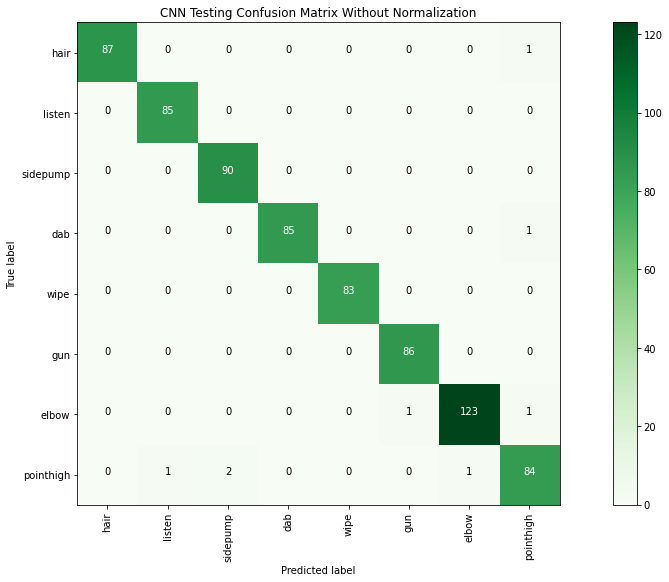

Normalized Confusion Matrix


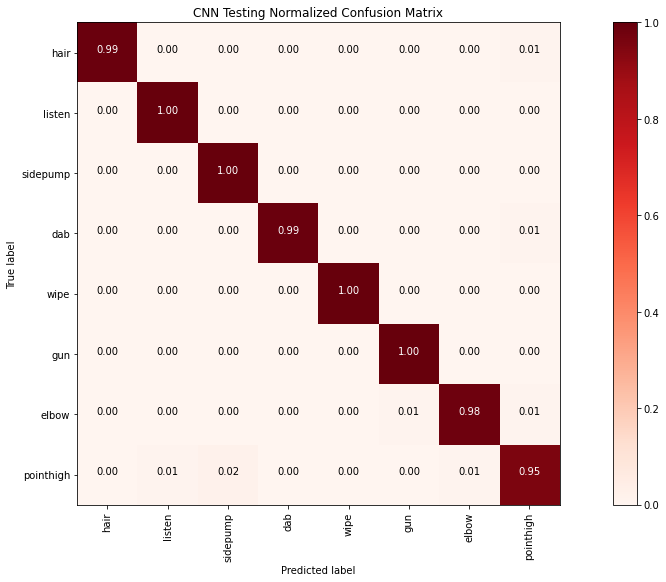

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(*cnn_test_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, title='CNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='CNN Testing Normalized Confusion Matrix')